# Goal: Find Most Accurate Model for Predicting Large Spikes in either over or undersupply of Bikes as early as possible
## Intuition: Holt - Winters may be the most effective use case here

Holt-Winters has several advantages for predicting short term spikes over many other models:
- Fast. SARIMA/SARIMAX is extremely powerful, but can take an extremely long time to fit. This might be okay for longer forecasts, but we'd like to be able to identify anomalous spike activity as fast as possible, and ideally be able to react to it in near real time. This makes Holt-Winters a potentially stronger candidate for the high-frequency, lower term use case.

- Reactive to percent change. Holt-Winters is based on Exponential smoothing, which makes it naturally quite responsive to sudden large (one might say "exponential" percent changes)

## Approach

1. The Forecast:
    - What will the net gain/loss of bikes into/out of a region be over six hour windows? I.e. Predict six hours out from each train set, what the total gain/loss will be of rides into/out of a given area (ANC). This would allow a bikeshare operator two "off peak" rebalancing periods before/after the typical commute day starts, as well as the opportunity to rebalance twice during the working day (or weekend) to account for unusual activity not anticipated by our longer term projections.
    
2. The Data Frequency:
    - We will sample at a short interval (try five minutes maybe), to simulate information coming in in real time, and attempting to make quick decisions about whether or not it is necessary to change our daily deployment plan. The high frequency should enable us to be alerted to changes in the forecast more quickly than for example if we updated every hour etc. Since we are making six hour predictions, we will take the sum of rides into/ out of each area over the previous six hour period for each data point available, and then resample to a five minute frequency to regularize our prediction frequency.

3. Baseline Models:
    - We will compare our models against two simple persistent lagged predictions, yesterday's six-hour change value at the same time, and the same value one hour ago.

4. Evaluation/Loss Functions:
    - Mean squared log error, since there are heavy spikes in many of these series, we'd like to capture how well our model predicts the spike and also lack thereof. This metric will penalize overprediction in periods of small change and reward accuracy in predicting peaks/troughs.
    
5. Validation Strategy:
    - We will use sklearn's TimeSeriesSplit to cross validate our results. This is a useful tool that allows us to split our data into multiple train/test sets on a rolling basis, since we're not able to randomly shuffle our inputs as in traditional cross validation.

6. Tuning Parameters:
    - We will try a seasonal period corresponding to 24 hours to model daily seasonality, and allow Holt-Winters ExponentialSmoothing method to fit best parameters. We will also try different combinations of seasonal trend and damped trend params.
    
7. Model Selection:
    - For each ANC we will choose the model with the best validated six hour predictions based on our evaluation metric of mean squared log error.

In [1]:
import pandas as pd
import numpy as np
import cabi.etl.transform as t
import cabi.model as m
import cabi.etl.load as l
import cabi.viz as v
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Select the ANC to model
col = '1A'

# Import the processed values from our database
series = l.load_counts(col)

series

time
2020-04-01 00:25:48    0
2020-04-01 00:27:59    0
2020-04-01 01:36:09    0
2020-04-01 01:39:17    0
2020-04-01 01:47:36   -1
                      ..
2020-08-01 01:52:27    0
2020-08-01 01:56:45    0
2020-08-01 02:50:22    0
2020-08-01 02:50:28    0
2020-08-01 08:13:39    0
Name: 1A, Length: 1319554, dtype: int64

In [3]:
from scipy.stats import mode

0 35230
CPU times: user 1.45 s, sys: 42.2 ms, total: 1.49 s
Wall time: 1.49 s


time
2020-04-01 00:00:00    0.0
2020-04-01 01:00:00   -1.0
2020-04-01 02:00:00   -2.0
2020-04-01 03:00:00   -3.0
2020-04-01 04:00:00   -3.0
                      ... 
2020-08-01 04:00:00    0.0
2020-08-01 05:00:00    0.0
2020-08-01 06:00:00    0.0
2020-08-01 07:00:00    0.0
2020-08-01 08:00:00    0.0
Freq: H, Name: 1A, Length: 2937, dtype: float64

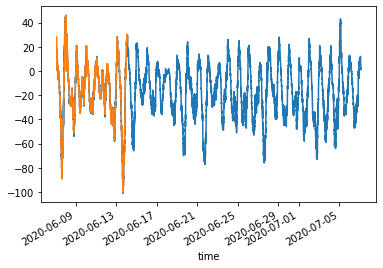

In [6]:
%%time

# Define our target from the raw counts:
# (Take the sum of plus minus count values over each six hour interval)
six_hour_change = series.rolling('6H').sum()

# Let's resample this retaining relatively high frequency to look at daily models:
# zero in na cases, else the most common value over five minute interval
# This is a limitation of time series approach, must be regular interval
hourly = six_hour_change.resample('1H').apply(lambda x: mode(x)[0] if mode(x)[0].size > 0 else 0)

print(five_minutes.isna().sum(), len(five_minutes))
# six_hour_change.plot()
six_hour_change[six_hour_change == six_hour_change.max()]
# This removes outliers and gives us about 2 months worth of data (almost 800K obs.)
# In this instance there is a highly unusual spike due to the George Floyd Protests
# Let's see how the models do without this as a more general use case, and then come
# back to it
# six_hour_change[six_hour_change.index > '2020-06-07 03:00:34'].plot()
six_hour_change[(six_hour_change.index > '2020-06-07 04:00:00') & (six_hour_change.index <= '2020-07-07 04:00:00')].plot()
five_minutes[(five_minutes.index > '2020-06-07 03:00:34') & (five_minutes.index < '2020-06-14 03:00:34')].plot()
five_minutes
hourly

## Moving on, but fix this

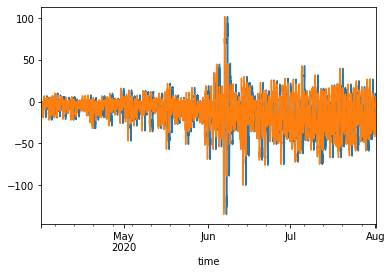

In [51]:
# 12 five hour periods per hour, 24 hours per day, 
# It's too late at night I dunno why the fuck this doesn't make sense to me right now
baseline_daily = five_minutes.shift(12*24)#.reindex(five_minutes.index)[(12*24):]
baseline_daily.plot()
five_minutes.plot()

## Just Bangin out the Workflow

In [55]:
# Split
train = five_minutes[(five_minutes.index > '2020-06-07 04:00:00') & (five_minutes.index <= '2020-07-07 04:00:00')]
test = five_minutes[(five_minutes.index > '2020-07-07 04:00:00') & (five_minutes.index <= '2020-07-14 04:00:00')]

In [69]:
len(test)

2016

In [65]:
%%time
#(Note the speed)

# Model
first_fit = ExponentialSmoothing(train, seasonal_periods=288, trend='add', seasonal='add').fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


CPU times: user 2.1 s, sys: 20.5 ms, total: 2.12 s
Wall time: 2.09 s


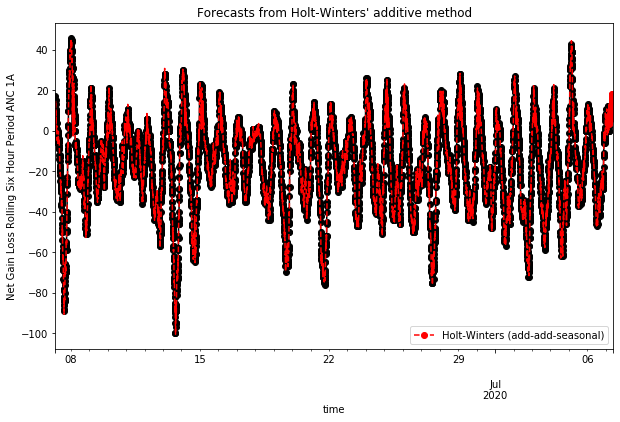

In [68]:
ax = train.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )
ax.set_ylabel("Net Gain Loss Rolling Six Hour Period ANC 1A")
ax.set_xlabel("Date")
first_fit.fittedvalues.plot(ax=ax, style='--', color='red')
first_fit.forecast(72).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

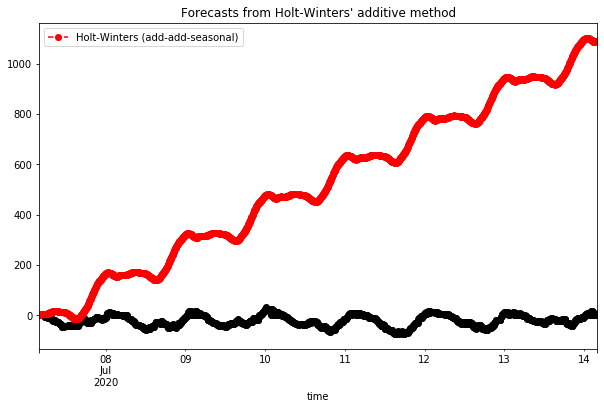

In [70]:
ax = test.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out one week" )
first_fit.forecast(2016).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

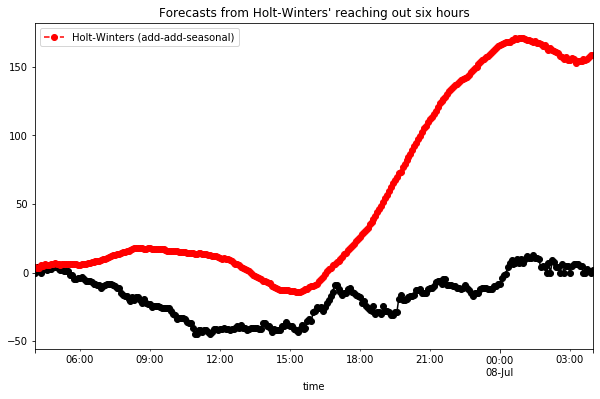

In [72]:
ax = test[:288].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out one day" )
first_fit.forecast(288).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

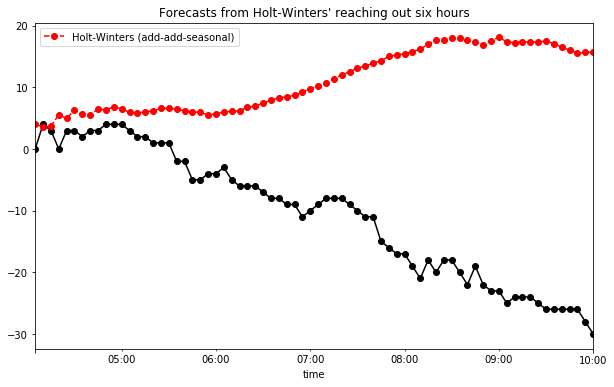

In [73]:
ax = test[:72].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out six hours" )
first_fit.forecast(72).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

## Remaining Steps in Workflow:

1. Evaluate 6 hour prediction accuracy
2. Validate with TimeSeriesSplit
3. Feed Multiple Params to tune
4. Function to Tie Everything Up with a Bow

In [74]:
%%time
#(Note the speed)

# Model
second_fit = ExponentialSmoothing(train, seasonal_periods=288, trend=None, seasonal='add').fit()

CPU times: user 450 ms, sys: 4.27 ms, total: 454 ms
Wall time: 444 ms


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


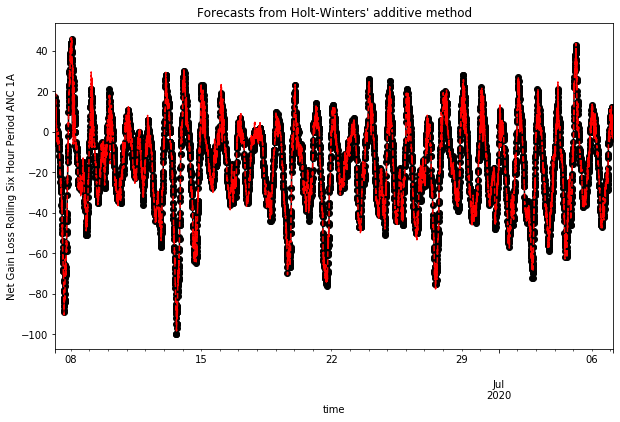

In [80]:
ax = train.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )
ax.set_ylabel("Net Gain Loss Rolling Six Hour Period ANC 1A")
ax.set_xlabel("Date")
second_fit.fittedvalues.plot(ax=ax, style='--', color='red')
# first_fit.forecast(72).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

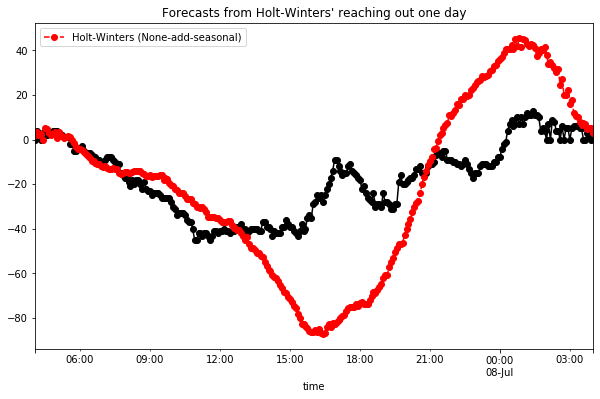

In [81]:
ax = test[:288].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out one day" )
second_fit.forecast(288).rename('Holt-Winters (None-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

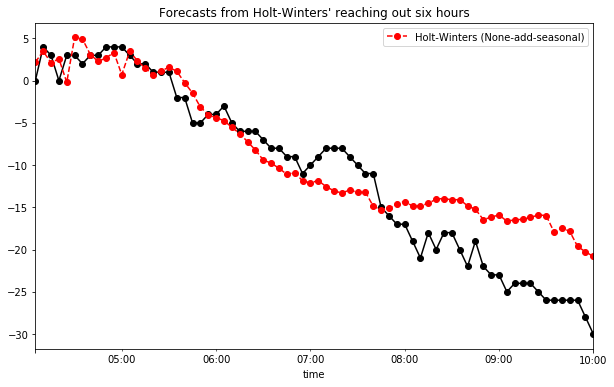

In [82]:
ax = test[:72].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out six hours" )
second_fit.forecast(72).rename('Holt-Winters (None-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

In [83]:
%%time
#(Note the speed)

# Model
third_fit = ExponentialSmoothing(train, seasonal_periods=288, trend='add', seasonal='add', damped=True).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


CPU times: user 6.21 s, sys: 192 ms, total: 6.41 s
Wall time: 6.27 s


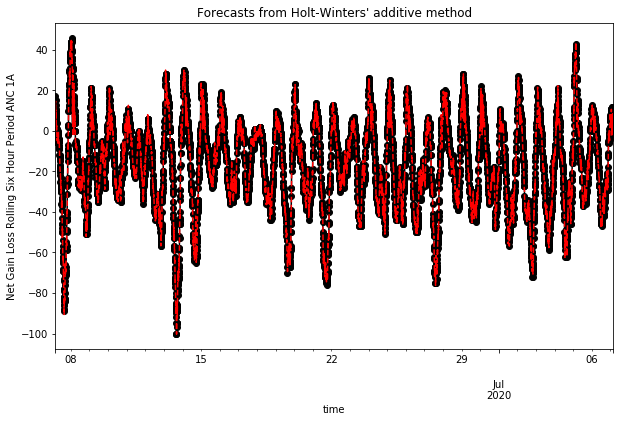

In [84]:
ax = train.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )
ax.set_ylabel("Net Gain Loss Rolling Six Hour Period ANC 1A")
ax.set_xlabel("Date")
third_fit.fittedvalues.plot(ax=ax, style='--', color='red')
# first_fit.forecast(72).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

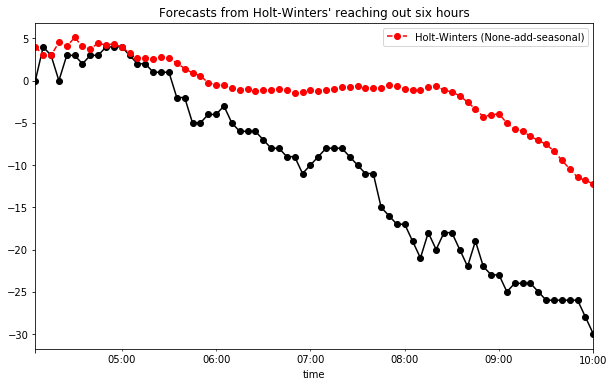

In [85]:
ax = test[:72].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out six hours" )
third_fit.forecast(72).rename('Holt-Winters (None-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

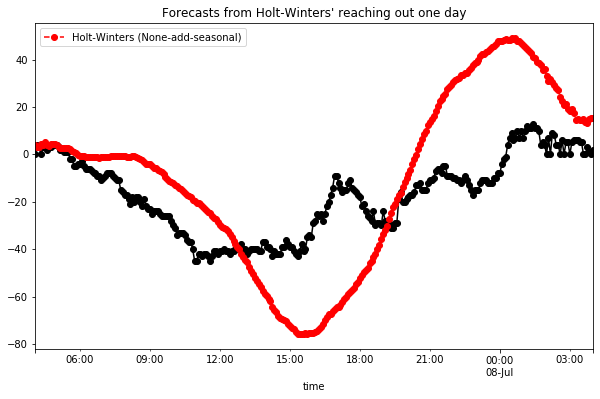

In [86]:
ax = test[:288].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out one day" )
third_fit.forecast(288).rename('Holt-Winters (None-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

In [91]:
%%time
#(Note the speed)

# Model
fourth_fit = ExponentialSmoothing(train, seasonal_periods=288, trend=None, seasonal=None).fit()

CPU times: user 23.8 ms, sys: 2.36 ms, total: 26.1 ms
Wall time: 19.4 ms


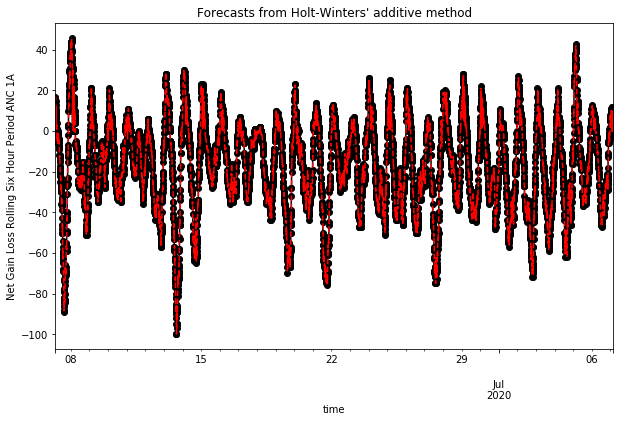

In [92]:
ax = train.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )
ax.set_ylabel("Net Gain Loss Rolling Six Hour Period ANC 1A")
ax.set_xlabel("Date")
fourth_fit.fittedvalues.plot(ax=ax, style='--', color='red')
# first_fit.forecast(72).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

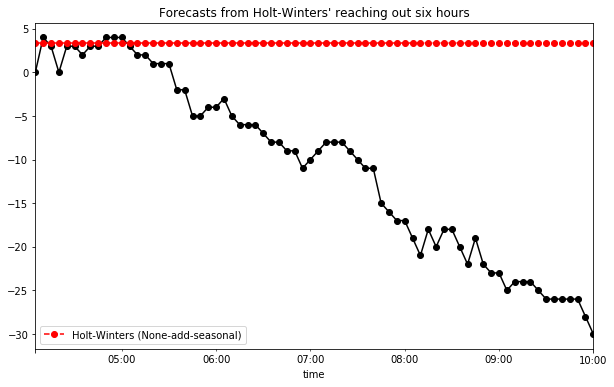

In [93]:
ax = test[:72].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out six hours" )
fourth_fit.forecast(72).rename('Holt-Winters (None-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

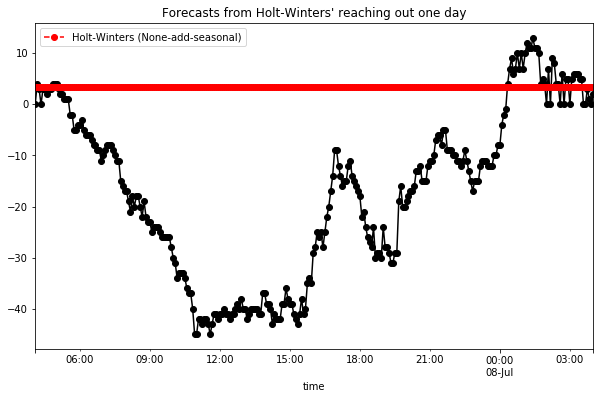

In [94]:
ax = test[:288].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' reaching out one day" )
fourth_fit.forecast(288).rename('Holt-Winters (None-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

In [7]:
# Split
train = hourly[(hourly.index > '2020-06-07 04:00:00') & (hourly.index <= '2020-07-07 04:00:00')]
test = hourly[(hourly.index > '2020-07-07 04:00:00') & (hourly.index <= '2020-07-14 04:00:00')]

In [8]:
model=SARIMAX(train, order=(2, 1, 1), 
                                        seasonal_order=(4, 1, 1, 24)).fit(disp=-1)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 1A   No. Observations:                  720
Model:             SARIMAX(2, 1, 1)x(4, 1, 1, 24)   Log Likelihood               -2389.521
Date:                            Wed, 02 Sep 2020   AIC                           4797.041
Time:                                    09:47:44   BIC                           4837.937
Sample:                                06-07-2020   HQIC                          4812.855
                                     - 07-07-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1442      0.344      0.419      0.675      -0.529       0.818
ar.L2          0.0943      0.050   

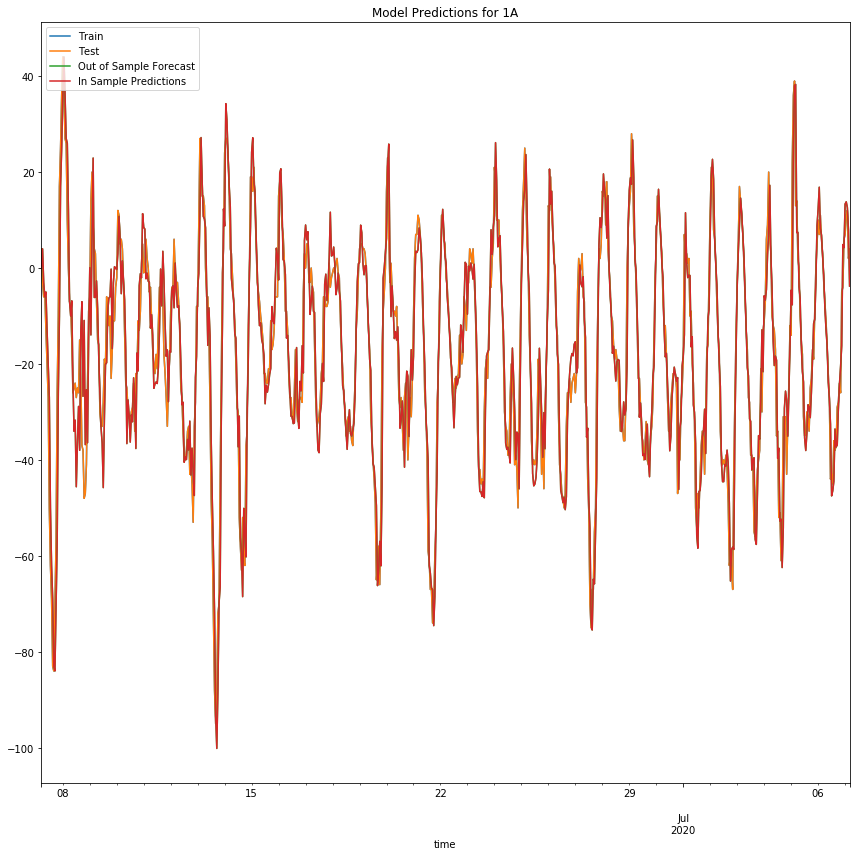

In [10]:
predictions = model.predict()
fig, ax = v.plot_series(train, preds= predictions, fig_size=(12,12))

# ax.set_xlim(ax.set_xlim([dt.date(2020, 5, 18), dt.date(2020, 5, 23)]))

In [11]:
plot_series = hourly[(hourly.index > '2020-06-07 04:00:00') & (hourly.index <= '2020-07-14 04:00:00')]

In [12]:
out_of_samp = model.predict(start=test.index[0], end=test.index[-1])


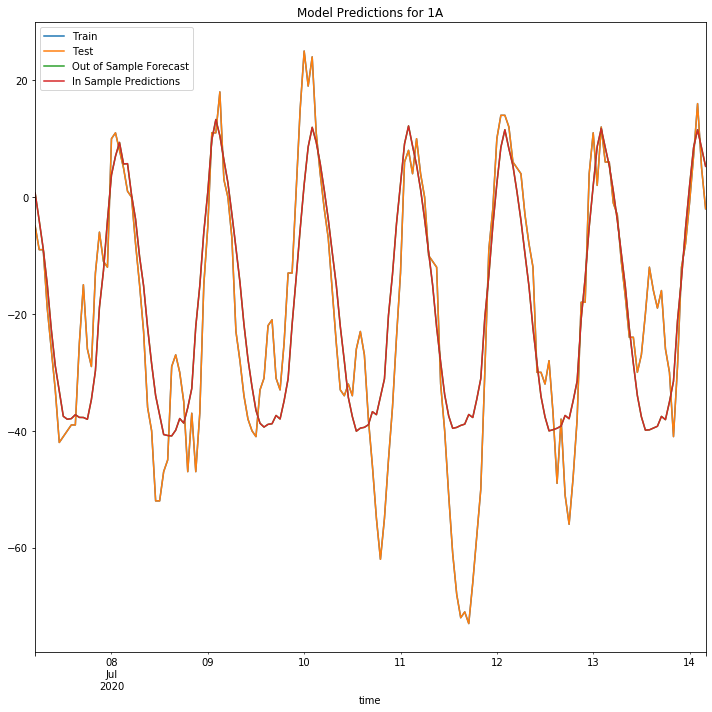

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2b42f190>)

In [13]:
v.plot_series(test, preds=out_of_samp)

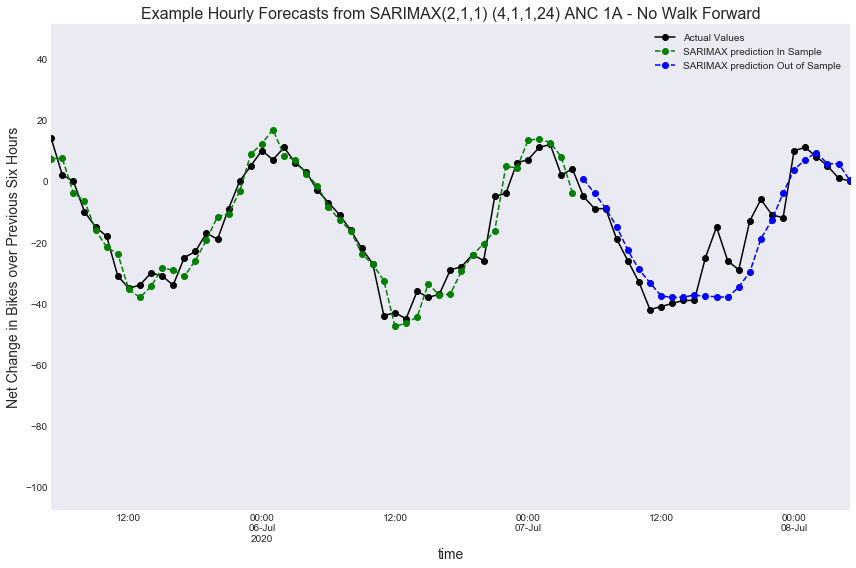

In [43]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(12,8))

plot_series.rename('Actual Values').plot(figsize=(12,8), marker='o', color='black', legend=True, ax=ax)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Net Change in Bikes over Previous Six Hours', fontsize=14)


# ax.set_yticklabels(fontsize=12)
ax.set_title("Example Hourly Forecasts from SARIMAX(2,1,1) (4,1,1,24) ANC 1A - No Walk Forward", fontsize=16)
predictions.rename('SARIMAX prediction In Sample').plot(ax=ax, style='--', marker='o', color='green', legend=True)
out_of_samp.rename('SARIMAX prediction Out of Sample').plot(ax=ax, style='--', marker='o', color='blue', legend=True)

ax = ax.set_xlim([train.index[-48], test.index[24]])


fig.tight_layout()

fig.savefig('../figures/sample_prediction1A.png')






In [62]:
lower = train.index[-48]#.to_pydatetime()
upper = test.index[24]#.to_pydatetime()

plot_series = plot_series[(plot_series.index > lower) & (plot_series.index <= upper)]
predictions = predictions[(predictions.index > lower) & (predictions.index <= upper)]
out_of_samp = out_of_samp[(out_of_samp.index > lower) & (out_of_samp.index <= upper)]

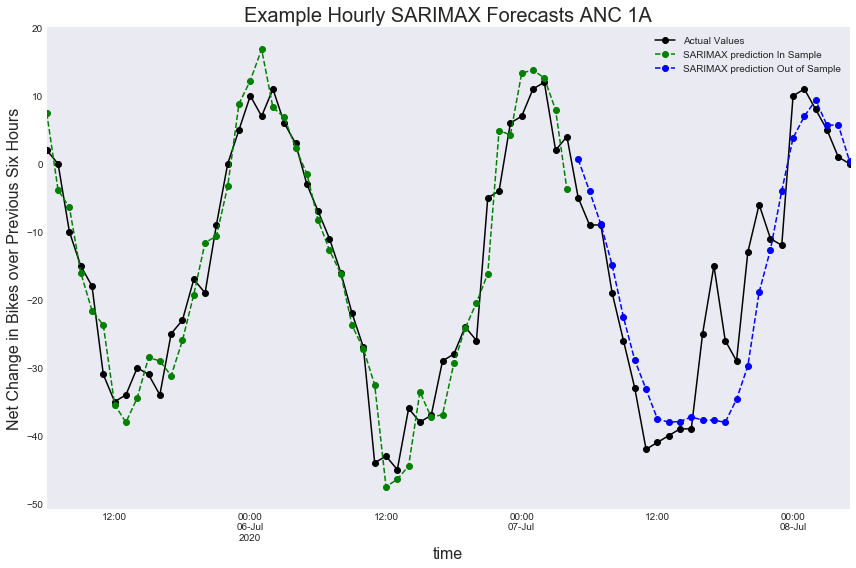

In [76]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(27,9))

plot_series.rename('Actual Values').plot(figsize=(12,8), marker='o', color='black', legend=True, ax=ax)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Net Change in Bikes over Previous Six Hours', fontsize=16)


# ax.set_yticklabels(fontsize=12)
ax.set_title("Example Hourly SARIMAX Forecasts ANC 1A", fontsize=20)
predictions.rename('SARIMAX prediction In Sample').plot(ax=ax, style='--', marker='o', color='green', legend=True)
out_of_samp.rename('SARIMAX prediction Out of Sample').plot(ax=ax, style='--', marker='o', color='blue', legend=True)

# ax = ax.set_xlim([train.index[-48], test.index[24]])
# plt.setp(ax.get_yticklabels(), fontsize=12)

fig.tight_layout()

fig.savefig('../figures/sample_prediction1A.png')

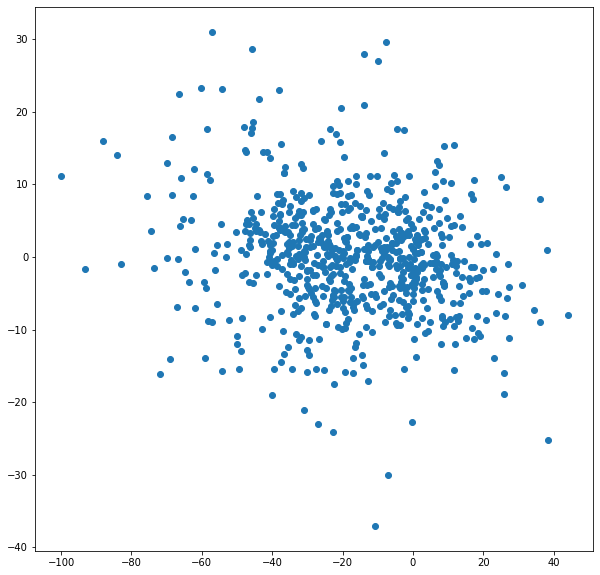

In [20]:
import matplotlib.pyplot as plt
residuals = model.resid.values
pred_vals = predictions.values

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x=pred_vals, y=residuals)